In [1]:
import numpy as np
import pandas as pd
import json
from gensim.models import KeyedVectors
import re
import nltk
import nltk.data
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim import models
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix
from gensim.models.keyedvectors import KeyedVectors
from langdetect import detect
import matplotlib.pyplot as plt

C:\Users\maria\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\maria\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
filename_b= 'BioWordVec_PubMed_MIMICIII_d200.vec.bin'
model_b= KeyedVectors.load_word2vec_format(filename_b, binary=True)

In [119]:
filename_g= 'GoogleNews-vectors-negative300.bin'
model_g= KeyedVectors.load_word2vec_format(filename_g, binary=True)

## Importación de los documentos

In [3]:
def leer_fichero(filename, num_documentos=10000):
    SKIP = 4
    registros = []
    with open(filename,"r") as f:
        i = 1 # número de línea que se está leyendo
        line = f.readline()
        while line:
            i += 1
            line = f.readline()

            # Saltar las primeras SKIP líneas
            if i <= SKIP:
                continue

            json_str = line[1:-1] # quitamos los primer y último caracteres
            try:
                registros.append(json.loads(json_str))
            except json.JSONDecodeError:
                pass

            # Salir cuando hayamos cargado num_documentos documentos
            if len(registros) == num_documentos:
                break
    return registros

In [4]:
filename = "litcovid2BioCJSON.json"
registros = leer_fichero(filename, num_documentos=1000000)

In [5]:
# Extraer texto de unos determinados passages
def extrae_texto(registro):
    to_exclude = [
        'fig', 'fig_caption','fig_footnote','fig_title_caption', 
        'ref', 
        'table', 'table_caption', 'table_foot', 'table_foot_title','table_footnote', 'table_title_caption', 
        'footnote',
        'abstract', 'abstract_title_1',
        ]
    return [passage['text'] for passage in registro['passages'] if passage['infons']['type'] not in to_exclude]
# Extraer abstract
def extrae_abstract(registro):
    return [passage['text'] for passage in registro['passages'] if passage['infons']['type'] in ['abstract']]

In [6]:
textos = pd.Series({r['_id'][:8]: " ".join(extrae_texto(r)) for r in registros})

In [7]:
#seleccionamos los artículos con al menos 300 palabras
mask = (textos.str.len() > 300)
testos = textos.loc[mask]

In [8]:
#cargamos los datos que contienen los abstracts y palabras clave
data =pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')
result = pd.concat([data, data_test], axis=0)

In [9]:
# nos quedamos con solo 3 columnas y con los abstracts que tengan al menos 350 palabras
result= result[['pmid','keywords','abstract']]
result=result[result['abstract'].str.len()>350]
result=result.reset_index().drop(columns='index')

In [10]:
testos=pd.DataFrame(testos,columns=['testoss'])
testos['pmid']=testos.index
testos['pmid'] = pd.Series(testos['pmid'], dtype="string")
result['pmid']=result['pmid'].astype(str)
result['pmid'] = pd.Series(result['pmid'], dtype="string")
datax=result.merge(testos,how='inner',on='pmid')
datax=datax.dropna()
datax=datax.reset_index().drop(columns='index')

In [11]:
#detectamos el idioma del texto
for i in range(1,12777):
    lang = detect(datax['testoss'][i])
    datax['lang']=lang

In [12]:
datax['lang'].unique()

array(['en'], dtype=object)

In [13]:
datax.shape

(12777, 5)

In [14]:
datax['length']=0
for i in range(0,12777):
    lens=len(datax['abstract'][i])
    datax['length'][i]=lens

<ipython-input-14-c943fdf1510a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datax['length'][i]=lens


In [15]:
datax.describe()

length
count  12777.000000
mean    1424.700008
std      597.815302
min      351.000000
25%     1032.000000
50%     1405.000000
75%     1741.000000
max    12809.000000

In [16]:
import matplotlib.pyplot as plot

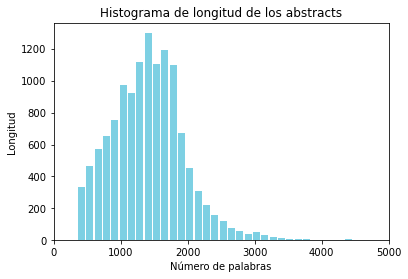

In [17]:
plot.hist(datax['length'],bins=100,  color='#7dd0e3', rwidth=0.85)
plot.title('Histograma de longitud de los abstracts')
plot.xlabel('Número de palabras')
plot.ylabel('Longitud')
plot.xlim(0,5000)
plot.show() 

### TF-IDF texto completo

In [18]:
#definimos las stop words
stop_words = set(stopwords.words("english"))
##Creamos una lista de stopwords customizadas
new_words = ["ha", "become", "put", "large", "also", "since", "one", "two", "new", "previously", "shown","ng","background","describe","recent","despite","wa","objective"]
stop_words = stop_words.union(new_words)

In [19]:
corpus = []
for i in range(0, 1000):
    #Eliminamos las  puntuaciones
    text = re.sub('[^a-zA-Z]', ' ', datax['testoss'][i])
    
    #Convertimos a minusculas
    text = text.lower()
    
    #eliminamos tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # eliminamos caracteres especiales o dígitos
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2 = " ".join(text2)
    corpus.append(text2)

In [20]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [21]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()

In [22]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [23]:
keystf_0=[]
for i in range(0, 1000):
    # fetch document for which keywords needs to be extracted
    doc=corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    keystf_0.append(keywords)

In [24]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keystf_1=[]
for i in keystf_0:
    k1=list(i)
    keystf_1.append(k1)
keystf = []
for i in range(0,1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keystf_1[i]))
    ##Convert to list from string
    text = text.split()
    keystf.append(text)

In [25]:
#convertimos al mismo formato las palabras dadas por los autores
keys2=[]
for i in range(0, 1000):
    k=datax['keywords'][i]
    keys2.append(k)
keys3=[]
for i in range(0, 1000):    
    k3=str(keys2[i]).split(';')
    keys3.append(k3)
keys4 = []
for i in range(0, 1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys3[i]))
    
    ##Convert to list from string
    text = text.split()
    
    ##Lemmatization
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    keys4.append(text)

In [26]:
def evaluate_keywords(proposed,groundtruth):

    proposed_set = set(proposed)
#     print(proposed_set)
    true_set = set(groundtruth)
#     print(true_set)
    true_positives = len(proposed_set.intersection(true_set))
    if len(proposed_set)==0:
        precision = 0
    else:
        # note denominator reflects total number of words
        # not total number of unique words
        precision = true_positives/float(len(proposed)) 
        jaccard= float(len(proposed_set.intersection(true_set)) / len(proposed_set.union(true_set)))

    if len(true_set)==0:
        recall = 0
    else:
        recall = true_positives/float(len(true_set))

    if precision + recall > 0:
        f1 = 2*precision*recall/float(precision + recall)
    else:
        f1 = 0
        

    return (precision, recall, f1, jaccard)

In [27]:
d=['s1_1','s2_1','s3_1','s4_1','s5_1','s6_1','s7_1','s8_1','s9_1','s10_1']

In [28]:
a=[]
al1=[]
al2=[]
al3=[]
al4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keystf[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    al1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    al2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    al3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    al4.append(aa4)


In [29]:
print(al1)
print(al2)
print(al3)
print(al4)


[0.365, 0.3265, 0.291, 0.26475, 0.24620000000000006, 0.2345, 0.22314285714285712, 0.21264285714285713, 0.20036507936507938, 0.19124285714285716]
[0.048139675459671426, 0.08400640280697153, 0.11224320664995555, 0.13394241420120237, 0.15464771599721627, 0.17573739074025788, 0.19489344995452143, 0.21129827868272474, 0.2231213630694971, 0.23529127181572163]
[0.08374541310436076, 0.13039613137518644, 0.15715297060841676, 0.17198438954198983, 0.18338099575780709, 0.1937599392099993, 0.20053320485876752, 0.2043603141084122, 0.2035866014099434, 0.2035516862366637]
[0.048139675459671426, 0.07741938605451203, 0.09542923363910201, 0.10589125797726859, 0.11435409814328851, 0.1218283085529295, 0.12682750987641658, 0.12968569025598792, 0.12930517129983543, 0.12991143999453744]


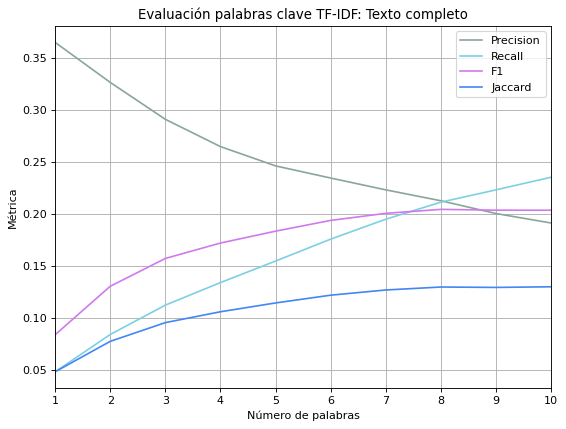

In [30]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,al1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,al2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,al3, 'b', label='F1',c='#d07aeb')
plt.plot(x,al4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF-IDF: Texto completo')
plt.show()

## Texto primeras 150 palabras - TF -IDF

In [31]:
corpus = []
for i in range(0, 1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', datax['testoss'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2=text2[:150]
    text2 = " ".join(text2)
    corpus.append(text2)

In [32]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [33]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()

In [34]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [35]:
keys_t1=[]
for i in range(0, 1000):
    # fetch document for which keywords needs to be extracted
    doc=corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    keys_t1.append(keywords)


In [36]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keys_t2=[]
for i in keys_t1:
    k1=list(i)
    keys_t2.append(k1)
keys_t = []
for i in range(0,1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys_t2[i]))
    ##Convert to list from string
    text = text.split()
    keys_t.append(text)

In [92]:
a=[]
am1=[]
am2=[]
am3=[]
am4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys_t[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    am1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    am2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    am3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    am4.append(aa4)

In [93]:
print(am1)
print(am2)
print(am3)
print(am4)

[0.36, 0.3065, 0.2626666666666666, 0.23525, 0.21600000000000003, 0.20206666666666667, 0.18613809523809519, 0.17469166666666666, 0.16478888888888893, 0.15746666666666667]
[0.04756885199853466, 0.07932928004085124, 0.10190544903010072, 0.1215276959610164, 0.1379114448102064, 0.1540496640621136, 0.16473767790012744, 0.17635682866032676, 0.1872007475467379, 0.19796091766557677]
[0.08284440399830095, 0.12321147955173617, 0.14264144683810626, 0.15508417230394622, 0.16265150582128696, 0.16871086196843793, 0.1685973846618806, 0.16919006196090827, 0.16898408554935326, 0.1691746464168768]
[0.04756885199853466, 0.07362805600860554, 0.08720456577494586, 0.09683707426927914, 0.10266165287981585, 0.10702201602665877, 0.10751297436150485, 0.10858552178918532, 0.1087894329282259, 0.10922228767644275]


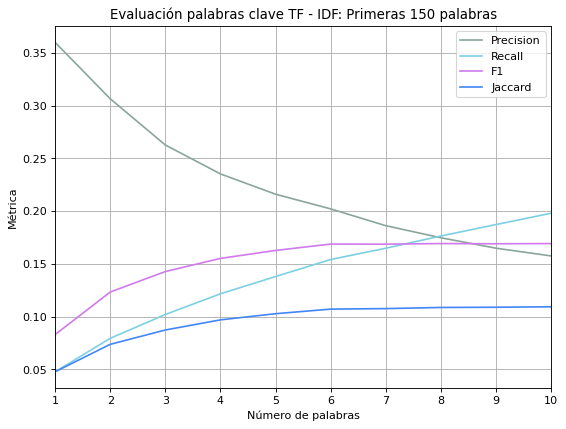

In [94]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,am1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,am2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,am3, 'b', label='F1',c='#d07aeb')
plt.plot(x,am4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF - IDF: Primeras 150 palabras')
plt.show()

In [40]:
datax['larg']=len(datax['abstract'])

In [41]:
datax.describe()

length     larg
count  12777.000000  12777.0
mean    1424.700008  12777.0
std      597.815302      0.0
min      351.000000  12777.0
25%     1032.000000  12777.0
50%     1405.000000  12777.0
75%     1741.000000  12777.0
max    12809.000000  12777.0

In [42]:
long=[]
for i in range(0,12777):
    larg=len(datax['abstract'][i])
    long.append(larg)

In [43]:
np.mean(long)

1424.7000078265633

## TF-IDF Abstract

In [44]:
corpus = []
for i in range(0, 1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', datax['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Remove stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lemmatisation
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
#     text = [lem.lemmatize(word, pos=x1[i][1]) for word in text if not word in stop_words] 
    text2=text2[:150]
    text2 = " ".join(text2)
    corpus.append(text2)

In [45]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [46]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# get feature names
feature_names=cv.get_feature_names()

In [47]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [48]:
keys_a1=[]
for i in range(0, 1000):
    # fetch document for which keywords needs to be extracted
    doc=corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    # now print the results
    keys_a1.append(keywords)

In [49]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keys_a2=[]
for i in keys_a1:
    k1=list(i)
    keys_a2.append(k1)
keys_a = []
for i in range(0,1000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', str(keys_a2[i]))
    ##Convert to list from string
    text = text.split()
    keys_a.append(text)

In [95]:
a=[]
an1=[]
an2=[]
an3=[]
an4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys_a[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    an1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    an2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    an3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    an4.append(aa4)

In [96]:
print(an1)
print(an2)
print(an3)
print(an4)

[0.378, 0.335, 0.30133333333333334, 0.2755, 0.254, 0.2368333333333333, 0.2248571428571428, 0.2115, 0.20144444444444445, 0.19110000000000002]
[0.05008635662869409, 0.08661727993580531, 0.11411100101950317, 0.1379510125717051, 0.1577579594217247, 0.17641351822405965, 0.19433017933424618, 0.20818697312954615, 0.22176601424666775, 0.23351159746032374]
[0.0869309520241254, 0.1341412188682402, 0.16073855350749, 0.17791174545096583, 0.18805074477264833, 0.1950786638495656, 0.20084160217175856, 0.20214293085270174, 0.20343675063822692, 0.2026284901436981]
[0.05008635662869409, 0.07986616779587581, 0.09725500584214267, 0.10903562403082447, 0.11663162495556843, 0.12284763005462795, 0.12721058081415737, 0.12870558195658122, 0.1297575077245999, 0.1289484032075766]


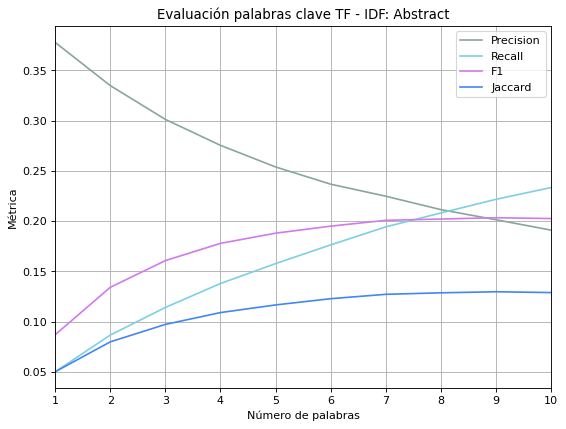

In [97]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,an1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,an2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,an3, 'b', label='F1',c='#d07aeb')
plt.plot(x,an4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF - IDF: Abstract')
plt.show()

### Entrenamiento propio modelo

In [53]:
# Function to convert a document to a sequence of words,
def text_to_wordlist(text, remove_stopwords=False):
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", text)

    # 3. Convert words to lower case and split them
    words = review_text.lower().split()

    return (words)


In [54]:
tokenizer = sent_tokenize
from nltk.tokenize import sent_tokenize

In [55]:
def text_to_sentences(text, tokenizer, remove_stopwords=False):
    # Function to split a text into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = nltk.sent_tokenize(text) # this gives us a list of sentences
    #
    # 2. Loop over each sentence
    sentences = []
    for sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(text_to_wordlist(sentence, remove_stopwords=False))

    return sentences

In [56]:
sentences = []

# Parsing sentences from training set
for i in range(0,12777):
    raw_sentences = nltk.sent_tokenize(datax['testoss'][i])
    for sentence in raw_sentences:
        sentences.append(text_to_wordlist(sentence, remove_stopwords=False))

In [57]:
num_features = 150
model = word2vec.Word2Vec(sentences, window=10, min_count=2,)
model_name = "w2v"
model.save(model_name)
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.

In [58]:
# model.init_sims(replace=True)
model = word2vec.Word2Vec.load(model_name)

### Extracción de palabras clave: Texto completo

In [59]:
def text_to_wordlist(text, remove_stopwords=True):
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", text)

    # 3. Convert words to lower case and split them, clean stopwords from model' vocabulary
    words = review_text.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    return (meaningful_words)

In [60]:
def get_feature_vec(words, model):
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key )
    clean_text = []
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            clean_text.append(model.wv[word])

    return clean_text

In [61]:
def powerMethod(A, x0, m, iter):
    n = A.shape[1]

    delta = m * (np.array([1] * n, dtype='float64') / n)
    for i in range(iter):
        x0 = np.dot((1 - m), np.dot(A, x0)) + delta
    return x0

In [62]:
key_word_list_m=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_m.append(keywords_list)

In [98]:
a=[]
as1=[]
as2=[]
as3=[]
as4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_m[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    as1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    as2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    as3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    as4.append(aa4)

In [99]:
print(as1)
print(as2)
print(as3)
print(as4)


[0.092, 0.0915, 0.087, 0.087, 0.08619999999999998, 0.0835, 0.08228571428571427, 0.080875, 0.078, 0.07790000000000001]
[0.011528498642740128, 0.023105438756290148, 0.03270779953116237, 0.04388988806955896, 0.05507296234822147, 0.06433810329527788, 0.0738840503006289, 0.08268874868531956, 0.08962705657625902, 0.09892712605012881]
[0.020255573958205538, 0.03614653957153958, 0.04628696060430988, 0.056588406465955934, 0.06508698516849552, 0.07020767272825015, 0.07515494758048104, 0.07885829330037271, 0.08036020293038854, 0.0839396440071332]
[0.011528498642740128, 0.020593069692605298, 0.026398434785934784, 0.03207063080635653, 0.03690477383207159, 0.039676121472200704, 0.042448673216336746, 0.04453168685957397, 0.04537420987760449, 0.04737946893043531]


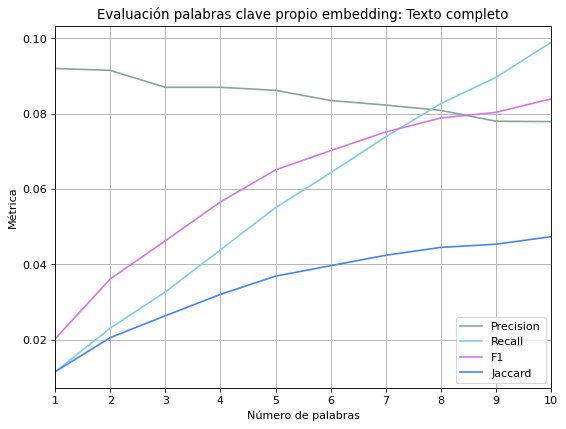

In [100]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,as1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,as2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,as3, 'b', label='F1',c='#d07aeb')
plt.plot(x,as4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio embedding: Texto completo')
plt.show()

## Propio embedding primeras 150 palabras

In [66]:
key_word_list_mm=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train_text=clean_train_text[:150]
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_mm.append(keywords_list)

In [67]:
print(key_word_list_mm[3])
print(key_word_list_m[3])

['kidney', 'confirmed', 'clinical', 'sars', 'china', 'crs', 'il', 'cytokine', 'severe', 'cases']
['crrt', 'membrane', 'elevated', 'corticosteroids', 'suggests', 'ifn', 'outlined', 'shown', 'cov', 'il']


In [101]:
a=[]
amm1=[]
amm2=[]
amm3=[]
amm4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_mm[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    amm1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    amm2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    amm3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    amm4.append(aa4)

In [102]:
print(amm1)
print(amm2)
print(amm3)
print(amm4)


[0.143, 0.134, 0.12533333333333332, 0.124, 0.1202, 0.118, 0.11485714285714284, 0.11375, 0.1118888888888889, 0.1101]
[0.018161650912838823, 0.0340689477432276, 0.04796399009767397, 0.06307792086791279, 0.07609664134162551, 0.08967415708353756, 0.10145450563505483, 0.11500483328727877, 0.1274464905464283, 0.13853320960652196]
[0.03180062188281843, 0.053136616844627685, 0.06753622142079403, 0.08102961339274779, 0.09019749319169304, 0.09832691677727953, 0.1038852503259859, 0.11029689762637877, 0.11498551919524949, 0.1184168471590201]
[0.018161650912838823, 0.03057401520647124, 0.038897138443107875, 0.04654934145227195, 0.051821951436529026, 0.05678587198606439, 0.06014195241871529, 0.063856935943886, 0.06682758176041324, 0.06916159945313924]


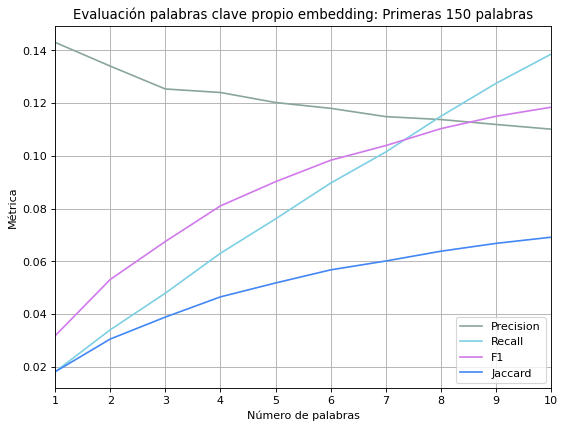

In [103]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,amm1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,amm2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,amm3, 'b', label='F1',c='#d07aeb')
plt.plot(x,amm4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio embedding: Primeras 150 palabras')
plt.show()

## Propio-embedding abstract

In [71]:
key_word_list_ma=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_ma.append(keywords_list)

In [104]:
a=[]
aj1=[]
aj2=[]
aj3=[]
aj4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_ma[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    aj1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    aj2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    aj3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    aj4.append(aa4)


In [105]:
print(aj1)
print(aj2)
print(aj3)
print(aj4)

[0.161, 0.1555, 0.15866666666666665, 0.15075, 0.14560000000000003, 0.1455, 0.14299999999999996, 0.139, 0.136, 0.13369999999999999]
[0.0213248074422997, 0.03867179634016692, 0.05893376708567851, 0.07402183788066477, 0.08873680883592212, 0.10652466615833825, 0.12362336490541162, 0.13604319766553075, 0.15059169212342927, 0.16488082639387153]
[0.037106979355827976, 0.060409932101371064, 0.08327590736233356, 0.09585538350037479, 0.10613670196179038, 0.1183415565780221, 0.1275652734835077, 0.1322391277599139, 0.13739967359043034, 0.14204127693458332]
[0.0213248074422997, 0.034542878711030664, 0.04770896823631444, 0.055135264059810556, 0.06160525324328029, 0.06896636178325613, 0.07480765715756896, 0.07788004709579358, 0.08111980831146394, 0.08426985225956836]


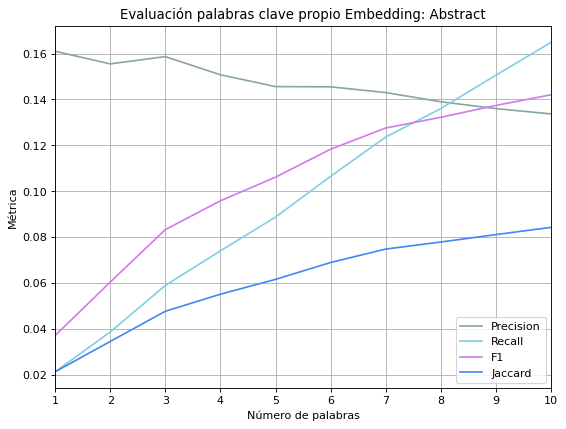

In [106]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,aj1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,aj2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,aj3, 'b', label='F1',c='#d07aeb')
plt.plot(x,aj4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio Embedding: Abstract')
plt.show()

### Modelo médico - Abstracts

In [120]:
def text_to_wordlist(text, remove_stopwords=True):
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", text)

    # 3. Convert words to lower case and split them, clean stopwords from model' vocabulary
    words = review_text.lower().split()
#     stops = set(stopwords.words('english'))
    stops = stop_words
    words2=[]
    for word in words:
        words2.append(lem.lemmatize(word))
    meaningful_words = [w for w in words2 if not w in stops]
    return (meaningful_words)

In [121]:
def get_feature_vec(words, model):
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index_to_key )
    clean_text = []
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            clean_text.append(model[word])

    return clean_text

In [122]:
def powerMethod(A, x0, m, iter):
    n = A.shape[1]

    delta = m * (np.array([1] * n, dtype='float64') / n)
    for i in range(iter):
        x0 = np.dot((1 - m), np.dot(A, x0)) + delta
    return x0

In [78]:
key_word_list_b=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_b.append(keywords_list)

In [107]:
a=[]
ac1=[]
ac2=[]
ac3=[]
ac4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_b[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ac1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ac2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ac3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ac4.append(aa4)


In [108]:
print(ac1)
print(ac2)
print(ac3)
print(ac4)

[0.139, 0.132, 0.12966666666666665, 0.1305, 0.127, 0.12383333333333334, 0.12328571428571426, 0.122125, 0.12000000000000001, 0.11930000000000002]
[0.017399648695817425, 0.03196376183081662, 0.0470478218998612, 0.0635899540324345, 0.07688938644127094, 0.09037536794342893, 0.10481570976964535, 0.11924112211959331, 0.13241665432732366, 0.14725831679207807]
[0.030450676894484944, 0.05018508358387548, 0.06708058041358572, 0.08284857074968568, 0.09253527355293123, 0.10073776476741104, 0.10910640316047145, 0.11611414019575042, 0.12111731348686167, 0.12682113347230176]
[0.017399648695817425, 0.028473094321362715, 0.03802561059146825, 0.047276049251128785, 0.05287739169381229, 0.05773012336970687, 0.0627095920533636, 0.06710778367694963, 0.07022547240037946, 0.07382877934053664]


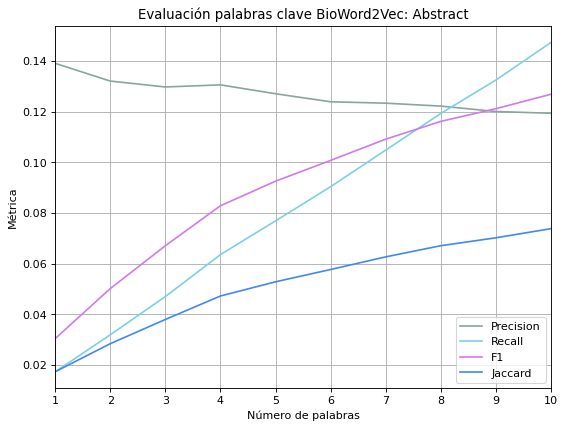

In [109]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ac1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ac2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ac3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ac4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Abstract')
plt.show()

## Modelo médico texto completo

In [82]:
key_word_list_bt=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_bt.append(keywords_list)

In [110]:
a=[]
ab1=[]
ab2=[]
ab3=[]
ab4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_bt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ab1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ab2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ab3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ab4.append(aa4)

In [111]:
print(ab1)
print(ab2)
print(ab3)
print(ab4)

[0.146, 0.11, 0.09966666666666665, 0.09275, 0.08819999999999999, 0.08266666666666665, 0.07914285714285714, 0.07775, 0.07511111111111111, 0.0738]
[0.018668081388967445, 0.026902541678419992, 0.03722912938809594, 0.0460324218257924, 0.054727349936896985, 0.06229160820614751, 0.06970698767961522, 0.07814417955121113, 0.08458998641892201, 0.09273755869958253]
[0.0320396337253346, 0.041606315297638155, 0.05207737375530915, 0.05906524795148365, 0.06477080553807117, 0.06800233213774232, 0.07104649318245773, 0.0748053132048443, 0.0764657081236966, 0.0790186408201963]
[0.018668081388967445, 0.02360534824359589, 0.029359934163932913, 0.03337283163623832, 0.036631645592313626, 0.038401233101762536, 0.0401778497884284, 0.04243667793830057, 0.04333313952278174, 0.04481365334644198]


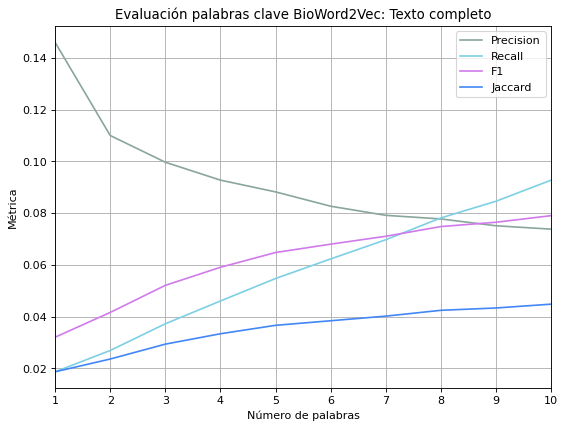

In [112]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ab1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ab2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ab3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ab4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Texto completo')
plt.show()

## Modelo médico primeras 150 palabras

In [86]:
key_word_list_btt=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train_text1=clean_train_text[:150]
    clean_train = []
    for words in clean_train_text1:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text1[words])
    key_word_list_btt.append(keywords_list)

In [113]:
a=[]
abb1=[]
abb2=[]
abb3=[]
abb4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_btt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    abb1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    abb2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    abb3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    abb4.append(aa4)

In [114]:
print(abb1)
print(abb2)
print(abb3)
print(abb4)

[0.091, 0.0925, 0.08766666666666666, 0.09175, 0.0904, 0.09416666666666666, 0.09457142857142856, 0.094875, 0.095, 0.09240000000000001]
[0.011080857115133264, 0.022886695617875787, 0.032428088375445016, 0.04608157457362935, 0.056733862868409916, 0.07040034032725176, 0.08297405254125034, 0.0942788234841018, 0.10563524843170319, 0.11356158351303054]
[0.019522590637703282, 0.036001437769317024, 0.046179712999173415, 0.059580412897701905, 0.06762822569034442, 0.07804117033188913, 0.08550304988777302, 0.09142064118785277, 0.09677047950157183, 0.09856312124418573]
[0.011080857115133264, 0.020492964891968585, 0.026276887448636675, 0.03415345280379413, 0.03867373072900836, 0.044601319797781966, 0.048858815106779675, 0.0523281635394701, 0.055577971321190675, 0.05662630640558621]


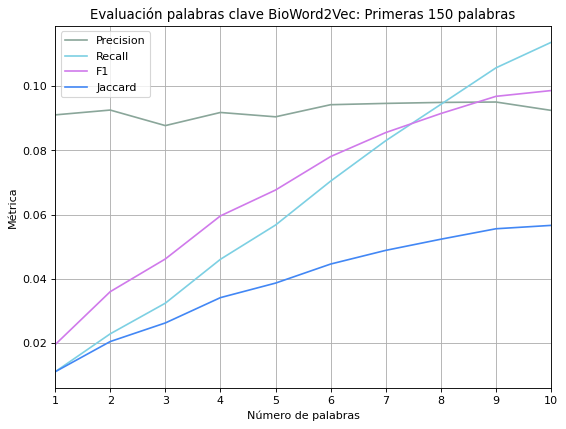

In [115]:
# x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,abb1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,abb2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,abb3, 'b', label='F1',c='#d07aeb')
plt.plot(x,abb4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Primeras 150 palabras')
plt.show()

## Modelo Google News abstract

In [136]:
key_word_list_g=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_g)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_g.append(keywords_list)

In [137]:
a=[]
ag1=[]
ag2=[]
ag3=[]
ag4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_g[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ag1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ag2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ag3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ag4.append(aa4)

In [138]:
print(ag1)
print(ag2)
print(ag3)
print(ag4)

[0.15, 0.147, 0.146, 0.14225, 0.13860000000000003, 0.1365, 0.1374285714285714, 0.13625, 0.13422222222222221, 0.1322]
[0.018343138890805133, 0.03525343143623699, 0.052775060477989875, 0.06839258280699423, 0.08341314865755234, 0.09826244021921601, 0.11617758423699162, 0.13089278527617473, 0.14536587093234857, 0.15934317734981351]
[0.03223560895457021, 0.05561569265189874, 0.07541513857400277, 0.08960404181372886, 0.10069020918811412, 0.11035163844843034, 0.12143108738410242, 0.12873021670416138, 0.13450059780539464, 0.1391841017469986]
[0.018343138890805133, 0.03166749788133903, 0.04316991020297709, 0.051431753553290195, 0.05792394737868883, 0.06372837124745565, 0.07052510738484628, 0.07516932197777264, 0.07886527939140572, 0.08191778768458959]


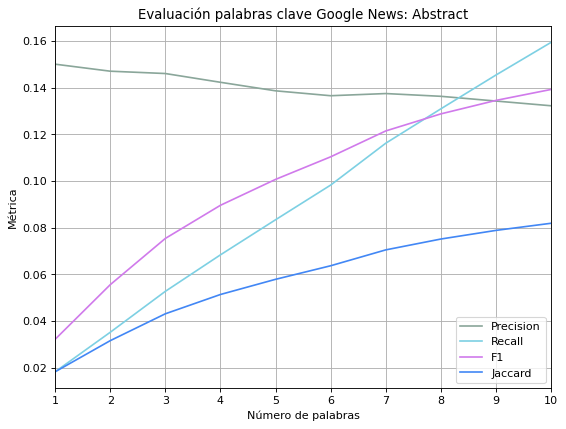

In [139]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ag1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ag2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ag3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ag4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave Google News: Abstract')
plt.show()

## Google News texto completo

In [140]:
key_word_list_gt=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_g)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_gt.append(keywords_list)

In [141]:
a=[]
agg1=[]
agg2=[]
agg3=[]
agg4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_gt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    agg1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    agg2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    agg3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    agg4.append(aa4)

In [142]:
print(agg1)
print(agg2)
print(agg3)
print(agg4)

[0.071, 0.071, 0.07566666666666666, 0.07975, 0.08220000000000001, 0.08133333333333331, 0.0807142857142857, 0.08, 0.08066666666666668, 0.0796]
[0.00882716521524571, 0.01778748528733049, 0.028112856991649563, 0.039758515396711984, 0.05179161850361541, 0.061121598959176356, 0.07026083553958941, 0.07994776321459758, 0.09019978682663263, 0.09930973788348771]
[0.015500630625131274, 0.027815213219461773, 0.03985515245237953, 0.05147864398811431, 0.06129527111504688, 0.06721851031720058, 0.07235245381681657, 0.07696158332788966, 0.08198665126547804, 0.08511720352043671]
[0.00882716521524571, 0.015720467470349376, 0.022415327032582887, 0.02900053645901169, 0.03453159386471104, 0.0378739105578671, 0.040573390751767406, 0.04312550978383125, 0.04594776884505667, 0.047649708211515866]


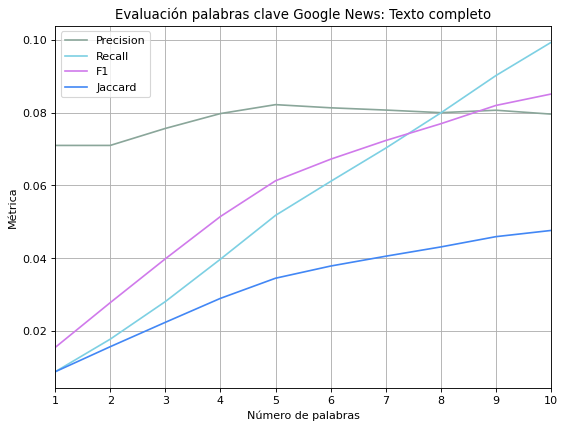

In [143]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,agg1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,agg2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,agg3, 'b', label='F1',c='#d07aeb')
plt.plot(x,agg4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave Google News: Texto completo')
plt.show()

## Google News primeras 150 p.

In [144]:
key_word_list_gtt=[]
for i in range(0, 1000):
# bag of word list without stopwords
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train_text1=clean_train_text[:150]
    clean_train = []
    for words in clean_train_text1:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_g)
    trainData = np.asarray(trainDataVecs)
    # similarity matrix, it is 30 times faster for sparse matrix
    # replace this with A.dot(A.T).todense() for sparse representation
    similarity = np.dot(trainData, trainData.T)

    # squared magnitude of preference vectors (number of occurrences)
    square_mag = np.diag(similarity)

    # inverse squared magnitude
    inv_square_mag = 1 / square_mag

    # if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
    inv_square_mag[np.isinf(inv_square_mag)] = 0

    # inverse of the magnitude
    inv_mag= np.sqrt(inv_square_mag)

    # cosine similarity (elementwise multiply by inverse magnitudes)
    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text1[words])
    key_word_list_gtt.append(keywords_list)

In [145]:
a=[]
agb1=[]
agb2=[]
agb3=[]
agb4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_gtt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    agb1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    agb2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    agb3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    agb4.append(aa4)

In [146]:
print(agb1)
print(agb2)
print(agb3)
print(agb4)

[0.154, 0.1475, 0.14433333333333334, 0.14175, 0.138, 0.13616666666666666, 0.13385714285714284, 0.13, 0.12855555555555553, 0.12630000000000002]
[0.020106791510003583, 0.03680122875060955, 0.05436833594681892, 0.07167741785648132, 0.08647113310665941, 0.10264550568970074, 0.11728818339165457, 0.1304405897908371, 0.14409302699856444, 0.1578728104504067]
[0.03495492943652948, 0.057515642961269896, 0.07658216552632988, 0.09186321886374045, 0.1024276200277173, 0.11277606794616248, 0.12033079961515858, 0.12532421013132494, 0.13071646760250036, 0.13501980753366752]
[0.020106791510003583, 0.03292882587880746, 0.04395762563544284, 0.05298172044322573, 0.05913194585712028, 0.06518128647345359, 0.0700526497984524, 0.07304691303928887, 0.07654787395656851, 0.07918767085765524]


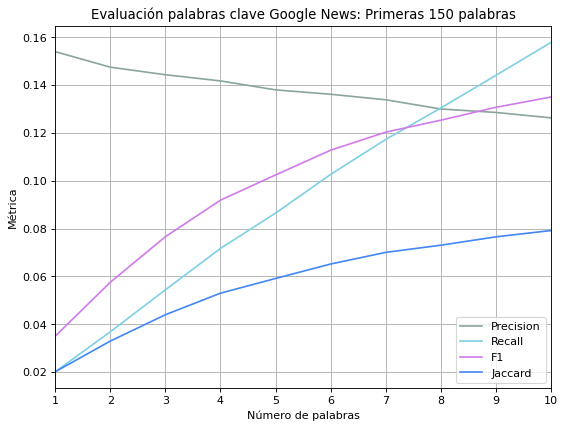

In [147]:
# x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,agb1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,agb2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,agb3, 'b', label='F1',c='#d07aeb')
plt.plot(x,agb4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave Google News: Primeras 150 palabras')
plt.show()